# Auto-ajuste por búsqueda aleatoria (randomized-search)

Un enfoque de búsqueda de cuadrícula tiene limitaciones.
- No escala cuando el número de parámetros para sintonizar está aumentando.
- La cuadrícula impondrá una regularidad durante la búsqueda que podría ser problemática.

Otro método para ajustar (sintonizar) los hiperparámetros es la *búsqueda aleatoria*.

## Nuestro modelo predictivo

In [ ]:

from sklearn import set_config

set_config(display="diagram")
import pandas as pd

adult_census = pd.read_csv("../../data/adult-census-numeric/full.csv")
# el target.

target_name = "class"
target = adult_census[target_name]
target

In [ ]:
# Eliminar duplicado "education-num"

data = adult_census.drop(columns=[target_name, "education-num"])
data.head()

In [ ]:
# dividir en set de entrenamiento y prueba.

from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42)

In [ ]:
# pipeline predictivo

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)
preprocessor = ColumnTransformer([
    ('cat_preprocessor', categorical_preprocessor, categorical_columns)],
    remainder='passthrough', sparse_threshold=0)

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4)),
])

model

## Ajuste usando  una búsqueda aleatoria
Podemos generar aleatoriamente los candidatos de parámetros.
- De hecho, tal enfoque evita la regularidad de la red.
- Por tanto, agregar más evaluaciones puede aumentar la resolución en cada dirección. 

Este es el caso en la situación (frecuente) en la que la elección de algunos hiperparámetros no es muy importante. 

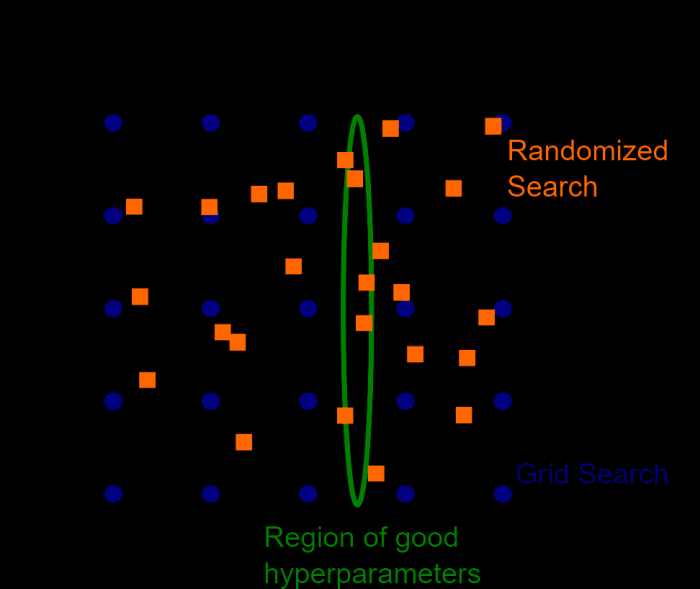

La clase **RandomizedSearchCV** permite una búsqueda estocástica. 
- Se usa de manera similar al GridSearchCV, pero las distribuciones de muestreo deben especificarse en lugar de los valores de los parámetros. 
- Por ejemplo, buscaremos candidatos utilizando una distribución uniforme de registro porque los parámetros en los que estamos interesados toman valores positivos con una escala de registro natural (.1 está tan cercano a 1, como lo es 10).

Optimizaremos otros 3 parámetros además de los que optimizamos con GridSearchCV:
- l2_regularización: corresponde a la fuerza de la regularización;
- min_samples_leaf: corresponde al número mínimo de muestras requeridas en una hoja;
- max_bins: corresponde al número máximo de contenedores para construir los histogramas.

In [ ]:
from scipy.stats import loguniform


class loguniform_int:
    """Versión valorada en entero de la distribución uniforme log"""
    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Muestra de variables aleatorias"""
        return self._distribution.rvs(*args, **kwargs).astype(int)


**Ahora, podemos definir la búsqueda aleatoria utilizando las diferentes distribuciones.**

⚠️ La ejecución de 10 iteraciones de 5-veces la validación cruzada para las parametrizaciones aleatorias de este modelo en este conjunto de datos puede tomar desde 10 segundos a varios minutos, dependiendo de la velocidad del ordendador y la cantidad de procesadores disponibles.

In [ ]:
%%time
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'classifier__l2_regularization': loguniform(1e-6, 1e3),
    'classifier__learning_rate': loguniform(0.001, 10),
    'classifier__max_leaf_nodes': loguniform_int(2, 256),
    'classifier__min_samples_leaf': loguniform_int(1, 100),
    'classifier__max_bins': loguniform_int(2, 255),
}

model_random_search = RandomizedSearchCV(
    model, param_distributions=param_distributions, n_iter=10,
    cv=5, verbose=1,
)
model_random_search.fit(data_train, target_train)

In [ ]:
# calculamos la precisión en el conjunto de pruebas.

accuracy = model_random_search.score(data_test, target_test)

print(f"La precisión de la prueba del mejor modelo es "
      f"{accuracy:.2f}")

In [ ]:
from pprint import pprint

print("Los mejores parámetros son:")
pprint(model_random_search.best_params_)

In [ ]:
# Podemos inspeccionar los resultados utilizando los atributos cv_results como lo hicimos anteriormente.

# obtener los nombres de los parámetros
column_results = [
    f"param_{name}" for name in param_distributions.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]

cv_results = pd.DataFrame(model_random_search.cv_results_)
cv_results = cv_results[column_results].sort_values(
    "mean_test_score", ascending=False)

def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

Tener en cuenta que el ajuste está limitado por el número de diferentes combinaciones de parámetros que se califican con la búsqueda aleatoria.

De hecho, puede haber otros conjuntos de parámetros que conducen a un rendimiento de generalización similar o mejor, pero que no se probaron en la búsqueda.

**En la práctica, una búsqueda aleatoria de hiperparámetro generalmente se ejecuta con una gran cantidad de iteraciones.**

### Ejemplo: 500 iteraciones
- Para evitar el costo de cálculo y aún hacer un análisis decente, cargaremos los resultados obtenidos de una búsqueda similar con 500 iteraciones.

In [ ]:
# Descomentar para generar 500 iteraciones

# model_random_search = RandomizedSearchCV(
#     model, param_distributions=param_distributions, n_iter=500,
#     n_jobs=2, cv=5)
# model_random_search.fit(data_train, target_train)
# cv_results =  pd.DataFrame(model_random_search.cv_results_)
# cv_results.to_csv("../../figures/randomized_search_results.csv")

In [ ]:
# Cargar resultados
cv_results = pd.read_csv("../../figures/randomized_search_results.csv", index_col=0)

(cv_results[column_results].rename(
   shorten_param, axis=1).sort_values("mean_test_score", ascending=False))

## Análisis

Definimos una función para eliminar los prefijos en los nombres de las columnas de hyperparámetros.

In [ ]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

Como tenemos más de 2 parámetros en nuestra búsqueda aleatoria, no podemos visualizar los resultados utilizando un mapa de calor.
- Podríamos hacerlo a pares, pero tener una proyección bidimensional de un problema multidimensional puede conducir a una interpretación incorrecta de los puntajes.

In [ ]:
import seaborn as sns
import numpy as np

df = pd.DataFrame(
    {
        "max_leaf_nodes": cv_results["max_leaf_nodes"],
        "learning_rate": cv_results["learning_rate"],
        "score_bin": pd.cut(
            cv_results["mean_test_score"], bins=np.linspace(0.5, 1.0, 6)
        ),
    }
)
sns.set_palette("YlGnBu_r")
ax = sns.scatterplot(
    data=df,
    x="max_leaf_nodes",
    y="learning_rate",
    hue="score_bin",
    s=50,
    color="k",
    edgecolor=None,
)
ax.set_xscale("log")
ax.set_yscale("log")

_ = ax.legend(
    title="mean_test_score", loc="center left", bbox_to_anchor=(1, 0.5)
)

En el gráfico anteriorvemos que los valores de rendimiento superior se encuentran en una banda de tasa de aprendizaje entre 0.01 y 1.0.
- pero no tenemos control en cómo los otros hiperparámetros interactúan con dichos valores para la tasa de aprendizaje.
- podemos visualizar todos los hiperparámetros al mismo tiempo utilizando una gráfica de coordenadas paralelas.

In [ ]:
# !pip install plotly

In [ ]:
import numpy as np
import plotly.express as px

fig = px.parallel_coordinates(
    cv_results.rename(shorten_param, axis=1).apply(
        {
            "learning_rate": np.log10,
            "max_leaf_nodes": np.log2,
            "max_bins": np.log2,
            "min_samples_leaf": np.log10,
            "l2_regularization": np.log10,
            "mean_test_score": lambda x: x,
        }
    ),
    color="mean_test_score",
    color_continuous_scale=px.colors.sequential.Viridis,
)
fig.show()

La gráfica de coordenadas paralelas muestra los valores de los hiperparámetros en diferentes columnas, mientras que la métrica de rendimiento está codificada por color.
- podemos inspeccionar rápidamente si hay una gama de hiperparámetros que funcionan o no.

En particular para esta búsqueda de hiperparameter, es interesante confirmar que las líneas amarillas (modelos de alto rendimiento) alcanzan valores intermedios para la velocidad de aprendizaje, es decir, los valores de tick entre -2 y 0 que corresponden a valores de velocidad de aprendizaje de 0.01 a 1.0 una vez que invertimos la transformación log10 para ese eje.

Pero ahora también podemos observar que no es posible seleccionar los modelos de mayor rendimiento seleccionando líneas del eje max_bins con valores de tick entre 1 y 3.

Los otros hiperparámetros no son muy sensibles.

Podemos verificar que si seleccionamos los valores de tick del eje Learning_Rate entre -1.5 y -0.5 y los valores de tick de Max_Bins entre 5 y 8, siempre seleccionamos modelos de alto rendimiento, cualesquiera que sean los valores de los otros hiperparámetros.

Hemos visto cómo explorar interactivamente los resultados de una gran búsqueda aleatoria con múltiples hiperparámetros de interacción.
En particular, observamos que algunos hiperparámetros tienen muy poco impacto en la puntuación de validación cruzada, mientras que otros deben ajustarse dentro de un rango específico para obtener modelos con buena precisión predictiva.

## **Ejercicio**

Para el dataset "house-prices/full.csv" y usando XGBoost Regressor: 
- Autoajusta max_depth usando randomized search.